#Imports

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import matplotlib.cm as cm
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.11.0


###Gdrive

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [3]:
# Folder where to work
%cd /gdrive/MyDrive/Ai

/gdrive/.shortcut-targets-by-id/1a2dYCfRfXGqVqDtICJwnE2mfsY5x9atR/Ai


In [4]:
!pip install visualkeras
import visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Random seed for reproducibility

seed = 69 

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
# We define some dictionaries that will contain the model hyperparameters we set for a given model training. Furthermore, those will be saved in a csv file in order to keep track of trials.
# This is also a way of making our code parametric


simulation_hyperparameters = {}

simulation_hyperparameters['epochs'] = 300
simulation_hyperparameters['patience'] = 20
simulation_hyperparameters['bacth_size'] = 32
simulation_hyperparameters['batch_size_augmentation'] = 32
simulation_hyperparameters['learing_rate'] = tfk.optimizers.Adam(10**-3) # tensorflow function that requires a float value in order to compute gradient descent with a spefic learning rate
simulation_hyperparameters['monitored_value'] = 'val_accuracy'
simulation_hyperparameters['monitoring_mode'] = 'max'

# This is a check for avoiding mistakes such as number of epochs smaller than patience
assert simulation_hyperparameters['epochs'] > simulation_hyperparameters['patience']

# These parameters are important for reshaping the images, before providing it to the imported model
preparation_hyperparameters={} 

preparation_hyperparameters['input_shape_height'] = 128
preparation_hyperparameters['resized_shape_height'] = 128 # We use twice this parameters for both height and width since the dataset is composed by square images 
# A 3 components vector will be composed in the following way: (new_height, new_width, depth (always equal to 3)) and it will be fed into the TL model

# These parameters are the ones used to build our classifier to be linked to the TL model imported
classification_hyperparameters={}

classification_hyperparameters['model_cool_name'] = 'VGG16_with_new_dataset' # This is a string we use to intuitively recognize our model
classification_hyperparameters['dense_neurons_1'] = 256 # number of neurons in the first Hidden Layer
classification_hyperparameters['dense_neurons_2'] = 128 # number of neurons in the second Hidden Layer
classification_hyperparameters['dense_neurons_3'] = 0 # number of neurons in the third Hidden Layer
classification_hyperparameters['dropout_level_0'] = 0.3 # percentage of dropout neurons between GAP/Flattening layer and the first Hidden Layer
classification_hyperparameters['dropout_level_1'] = 0.3 # percentage of dropout neurons in the first Hidden Layer
classification_hyperparameters['dropout_level_2'] = 0.3 # percentage of dropout neurons in the second Hidden Layer
classification_hyperparameters['dropout_level_3'] = 0.3 # percentage of dropout neurons in the third Hidden Layer
classification_hyperparameters['activation_function_1'] = 'relu' # activation function in the first Hidden Layer
classification_hyperparameters['activation_function_2'] = 'relu' # activation function in the second Hidden Layer
classification_hyperparameters['activation_function_3'] = 'relu' # activation function in the third Hidden Layer
classification_hyperparameters['output_shape'] = 3 # number of neurons in the Output Layer (equal to the number of classes to be classified)


frozen_hyperparameters = {**simulation_hyperparameters,**preparation_hyperparameters,**classification_hyperparameters}

In [7]:
labels = ['N','P','T']

In [8]:
model = tfk.models.load_model('Primo_training_VGG_tuned no BN always128 with Negatives augmentation no H-flip CW median')

#Explainability

##Load image
Here we load the image for which we want to compute the explaination

In [ ]:
T_target_path = 'Dataset/test/P'
lista_imagini = os.listdir(T_target_path)[1:]

In [ ]:
from PIL import Image
import cv2
from random import randint

lista_imagini = os.listdir(T_target_path)[1:]

a=randint(0,len(lista_imagini))
# Open an image file
original_image = Image.open(os.path.join(T_target_path, lista_imagini[a])).resize((128,128))

exp_image= np.array(original_image)
exp_image = cv2.medianBlur(exp_image,5)
exp_image_1channel = np.expand_dims(exp_image,axis=-1)

exp_image=np.concatenate((exp_image_1channel,exp_image_1channel,exp_image_1channel),axis=-1)

In [9]:
import cv2 as cv
def Median(image_pre):
    
    processed_image = cv.medianBlur(image_pre,3)
    
    return processed_image

dataset_dir = 'Negative Dataset Truncated'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

test_set = ImageDataGenerator(preprocessing_function=Median).flow_from_directory(directory = test_dir,
                                                  target_size = (preparation_hyperparameters['input_shape_height'],preparation_hyperparameters['input_shape_height']),
                                                  color_mode = 'rgb',
                                                  classes = None, 
                                                  class_mode = 'categorical',
                                                  batch_size = 32,
                                                  shuffle = False,
                                                  seed = seed)

Found 1548 images belonging to 3 classes.


## Grad-CAM

This technique consists of computing the gradient of the target class score with respect to the feature map of a convolutional layer and then using these gradients to weight the feature maps. So, we can compute a coarse localization map highlighting the important regions in the image for predicting that specific concept.

In [ ]:
#@title Implementation
import cv2

def GradCam(model, img_array, layer_name, eps, output_node=0):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    


    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''
    

    gradModel = tfk.Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).get_output_at(output_node),
				model.output])

    heatmaps_vector = []
    predictions_vector = []
    
    for i in range(3):
        
    
        with tf.GradientTape() as tape:
                # cast the image tensor to a float-32 data type, pass the
                # image through the gradient model, and grab the loss
                # associated with the specific class index
          inputs = tf.cast(img_array, tf.float32) #we use the preprocessed image
          (convOutputs, predictions) = gradModel(inputs)
          loss = predictions[:, i]
            # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs , "float32")
        castGrads = tf.cast(grads , "float32")
        guidedGrads = castConvOutputs * castGrads * grads
            # the convolution and guided gradients have a batch dimension
            # (which we don't need) so let's grab the volume itself and
            # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]
        # compute the average of the gradient values, and using them
            # as weights, compute the ponderation of the filters with
            # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
            # the output class activation map to match the input image
            # dimensions
        (w, h) = (img_array.shape[2], img_array.shape[1])
        pre_heatmap = cv2.resize(cam.numpy(), (w, h))
        
        hmin = pre_heatmap.min()
        hmax = pre_heatmap.max()
        hminn = np.min(pre_heatmap)
        hmaxn = np.max(pre_heatmap)
        
        #print(hmin,hmax,hminn,hmaxn)
        
        
            # normalize the heatmap such that all values lie in the range
            # [0, 1], scale the resulting values to the range [0, 255],
            # and then convert to an unsigned 8-bit integer
        numer = pre_heatmap - pre_heatmap.min()
        
        denom = (pre_heatmap.max() - pre_heatmap.min()) + eps
        heatmap = numer / denom
        
        hmin_after = heatmap.min()
        hmax_after = heatmap.max()
        
        
            # return the resulting heatmap to the calling function
        heatmaps_vector.append((heatmap))
    
    return heatmaps_vector,predictions,gradModel


###Get the heatmap

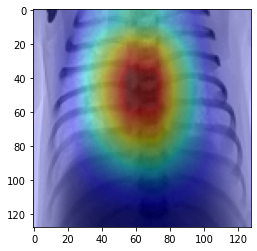

In [ ]:
grad_cams,predictions,gradModel=GradCam(model,np.expand_dims(exp_image, axis=0),'block5_conv3',eps=10e-60,output_node=0)

img=np.array(original_image)
img = np.expand_dims(img,axis=-1)
img=np.concatenate((img,img,img),axis=-1)


prediction=np.argmax(predictions)
        
        
heatmap=grad_cams[prediction]
          

        # Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

        # Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))

        #heatmap = sigmoid(heatmap, 50, thresh, 1)

jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

plt.imshow(superimposed_img)


## LIME

Its basic idea is to approximate the behaviour of a black-box model locally by training a simple, interpretable model on a small subset of data close to our point of interest. First a set of perturbed samples (inputs with small variations) is generated around the point of interest. Then, the black box model is used to predict the outcomes of these perturbed samples. 
Finally, LIME trains a simple and interpretable model such as a linear model or a decision tree, on the perturbed samples and their corresponding predictions. The simple model is then used to explain the predictions of the black box model.

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 18.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=f946d55da5198cb9b8929cf19a05983d2431422bfb487233ea18675e1d56d339
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [ ]:
import lime
%load_ext autoreload
%autoreload 2
import os,sys
from lime import lime_image

###Load the lime explainer
This is the simple, understandable model that will be used to explain.

In [ ]:
explainer = lime_image.LimeImageExplainer()

###Train the explainer

In [ ]:
explanation = explainer.explain_instance(exp_image.astype('double'), model.predict,  hide_color=0, num_samples=10000)


  0%|          | 0/10000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 20ms/step


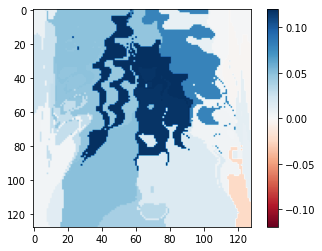

In [ ]:
#Select the top class
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

## Occlusion
It works by blocking portions of the image and observing how the model’s prediction is affected. 

In [ ]:
#@title Get occlusion 

def get_occlusion(image_to_be_explained_, img_target_, num_occ_patches, num_inv_occ_patches):
  sense_map = get_sensitivity_map(model, image_to_be_explained_, img_target_, PATCH_SIZE= int(np.round(image_to_be_explained_.shape[0]/num_occ_patches)))
  inverted_sense_map = get_patch_preservation_sensitivity_map(model, image_to_be_explained_, img_target_, PATCH_SIZE= int(np.round(image_to_be_explained_.shape[0]/num_inv_occ_patches)))

  return sense_map, inverted_sense_map

def visualize_occlusion(image_to_be_explained_, img_target_, sense_map, inverted_sense_map):
  fig, axes = plt.subplots(1, 3, figsize=(25,30))
  axes.flat
  axes[0].imshow(np.double(image_to_be_explained_/255),cmap='gray')
  axes[0].set_title("Inuput image - "+labels[img_target_])
  axes[0].axis('off')

  axes[1].imshow(image_to_be_explained_, cmap='gray')
  im=axes[1].imshow(sense_map, cmap='YlGnBu', alpha=0.7)
  axes[1].set_title("Traditional occlusion")
  axes[1].axis('off')
  cax = make_axes_locatable(axes[1]).append_axes("right", size="5%", pad=0.05) 
  fig.colorbar(im, cax=cax)

  axes[2].imshow(image_to_be_explained_, cmap='gray')
  im=axes[2].imshow(inverted_sense_map, cmap='YlGnBu', alpha=0.5)
  axes[2].set_title("Inverted occlusion")
  axes[2].axis('off')
  cax = make_axes_locatable(axes[2]).append_axes("right", size="5%", pad=0.05) 
  fig.colorbar(im, cax=cax)


In [ ]:
#@title Occlusion functions

# Create function to apply a black patch on an image
def apply_black_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] = 0

    return patched_image

# Create function to get the sensitivity map
def get_sensitivity_map(model, pure_image, pure_image_class, PATCH_SIZE=8):
    # Create a blank sensitivity map
    img = tf.keras.preprocessing.image.img_to_array(pure_image)
    img = img[:,:,:]

    sensitivity_map = np.zeros((img.shape[0], img.shape[1]))

    # Iterate the patch over the image
    for top_left_x in range(0, img.shape[0], PATCH_SIZE):
        for top_left_y in range(0, img.shape[1], PATCH_SIZE):
            patched_image = apply_black_patch(img, top_left_x, top_left_y, PATCH_SIZE)
            input = np.array([patched_image])
            resized_input = input
            print(resized_input.shape)
            predicted_classes = model.predict(resized_input)[0]
            confidence = predicted_classes[pure_image_class]
            
            # Save confidence for this specific patched image in map
            sensitivity_map[
                top_left_y:top_left_y + PATCH_SIZE,
                top_left_x:top_left_x + PATCH_SIZE,
            ] = confidence

    return sensitivity_map

In [ ]:
#@title Inverted occlusion functions
# Create function to make the whole image black except for the patch
def image_patch_preservation(image, top_left_x, top_left_y, patch_size):
    patched_image = np.zeros(image.shape)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] = image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size]

    return patched_image

# Create function to get the patch preservation sensitivity map
def get_patch_preservation_sensitivity_map(model, pure_image, pure_image_class, PATCH_SIZE=8):
    # Create a blank sensitivity map
    img = tf.keras.preprocessing.image.img_to_array(pure_image)
    img = img[:,:,:]

    sensitivity_map = np.zeros((img.shape[0], img.shape[1]))

    # Iterate the patch over the image
    for top_left_x in range(0, img.shape[0], PATCH_SIZE):
        for top_left_y in range(0, img.shape[1], PATCH_SIZE):
            patched_image = image_patch_preservation(img, top_left_x, top_left_y, PATCH_SIZE)
            input = np.array([patched_image])
            resized_input = input
            predicted_classes = model.predict(resized_input)[0]
            confidence = predicted_classes[pure_image_class]
            
            # Save confidence for this specific patched image in map
            sensitivity_map[
                top_left_y:top_left_y + PATCH_SIZE,
                top_left_x:top_left_x + PATCH_SIZE,
            ] = confidence

    return sensitivity_map

In [ ]:
labels = ['N','P','T']

list_labels = {
    'N' : 0,
    'P' : 1,
    'T': 2,
    }

In [ ]:
#Compute the occlusion
image_to_be_explained_ = exp_image
sense_map, inverted_sense_map = get_occlusion(image_to_be_explained_, list_labels['N'] , 15, 3)

(1, 128, 128, 3)
1/1 [==============================] - 0s 22ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 21ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 19ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 22ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 21ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 20ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 22ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 24ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 23ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 22ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 20ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 27ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 22ms/step
(1, 128, 128, 3)
1/1 [==============================] - 0s 21ms/step
(1, 128, 128, 3)
1/1 [============

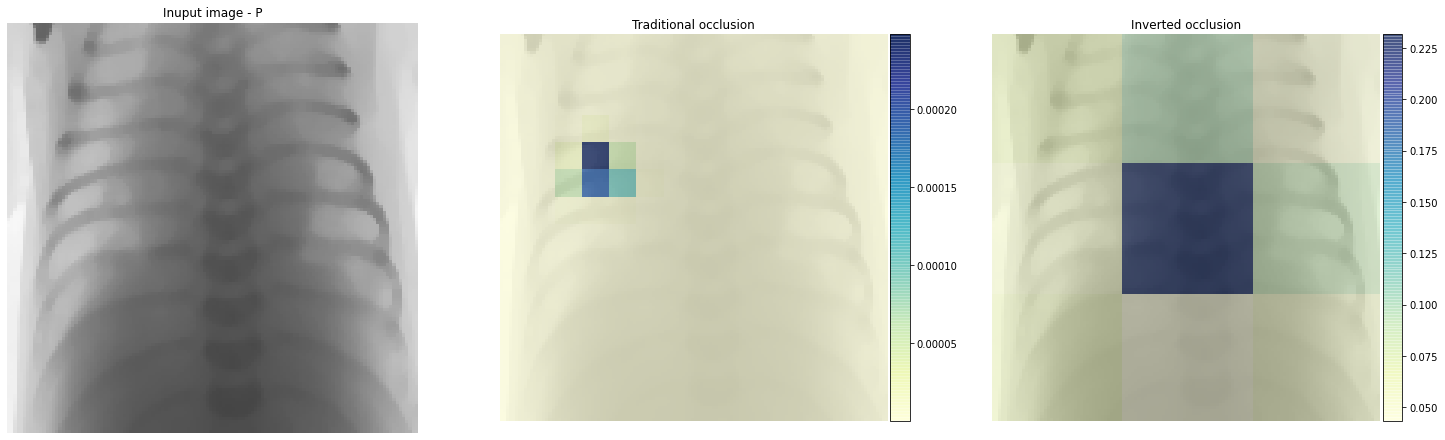

In [ ]:
#Visualize the occlusion
from mpl_toolkits.axes_grid1 import make_axes_locatable
visualize_occlusion(image_to_be_explained_, 1, sense_map, inverted_sense_map)

##Monte Carlo Dropout

In [10]:
def jain_fairness(softmax_output):
    
    n=softmax_output.shape[0]
    
    pre_num = np.sum(softmax_output)
    num = pre_num*pre_num
    
#     print(num)
    
    den = n*sum(i * i for i in softmax_output)
    
#     print(den)
#     print(n)
    
    jain_index = num/den
    
    return jain_index

In [11]:
model.summary()

Model: "VGG16_with_new_dataset"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 128, 128, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 128, 128, 3)      0         
 a)                                                              
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 

In [12]:
# input
from tensorflow.keras.layers import Input, Conv2D 
from tensorflow.keras.layers import MaxPool2D, Flatten, Dense

input = tfkl.Input(shape =(128,128,3))
# 1st Conv Block

p=tfk.applications.vgg16.preprocess_input(input)

x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(p)
x = Conv2D (filters =64, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
x = tfkl.Dropout(0.1)(x)
# 2nd Conv Block

x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =128, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
x = tfkl.Dropout(0.1)(x)
# 3rd Conv block

x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =256, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
x = tfkl.Dropout(0.1)(x)
# 4th Conv block

x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
x = tfkl.Dropout(0.1)(x)

# 5th Conv block

x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = Conv2D (filters =512, kernel_size =3, padding ='same', activation='relu')(x)
x = MaxPool2D(pool_size =2, strides =2, padding ='same')(x)
# Fully connected layers

x = tfkl.GlobalAveragePooling2D()(x) 
x = tfkl.Dropout(0.1)(x)
x = Dense(units = 256, activation ='relu')(x)
x = tfkl.Dropout(0.1)(x)
output = Dense(units = 3, activation ='softmax')(x)
# creating the model

dropout_model = tfk.Model (inputs=input, outputs =output)
dropout_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 128, 128, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 128, 128, 3)      0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                           

In [13]:
myweights=[] 
for layer in model.layers:
    
    myweight = layer.get_weights()
    myweights.append(myweight)

In [14]:
len(myweights)

26

In [15]:
dropout_model.layers[3].set_weights(myweights[3])
dropout_model.layers[4].set_weights(myweights[4])
#---
dropout_model.layers[7].set_weights(myweights[6])
dropout_model.layers[8].set_weights(myweights[7])
#--
dropout_model.layers[11].set_weights(myweights[9])
dropout_model.layers[12].set_weights(myweights[10])
dropout_model.layers[13].set_weights(myweights[11])
#--
dropout_model.layers[16].set_weights(myweights[13])
dropout_model.layers[17].set_weights(myweights[14])
dropout_model.layers[18].set_weights(myweights[15])
#--
dropout_model.layers[21].set_weights(myweights[17])
dropout_model.layers[22].set_weights(myweights[18])
dropout_model.layers[23].set_weights(myweights[19])
#--
dropout_model.layers[27].set_weights(myweights[23])
dropout_model.layers[29].set_weights(myweights[25])

In [16]:
all_images=[]

for i in range(49):
    
    batch,classe = next(test_set)
    
    if i<48:
        
        for i in range(32):
            
            image = batch[i]
            all_images.append(image)
    else:
        
        for i in range(11):
            
            image = batch[i]
            all_images.append(image)

In [ ]:
median_predictions=[]
mean_predictions=[]
ensemble_pct_97_5 = []
ensemble_pct_2_5 = []
ensemble_pct_diff = []

predictions = model.predict_generator(test_set)

for i in range(len(predictions)):
    
    monte_carlo_predictions=[]
    
    print('Inizio ciclo per immagine',i)
    
    for j in range(100):
        
        prediction = dropout_model(np.expand_dims(all_images[i],axis=0),training=True).numpy().squeeze()
        monte_carlo_predictions.append(prediction)
        
        print('Prediction n:',j, prediction,'con somma pari a',np.sum(prediction))
    
    median_prediction = np.median(monte_carlo_predictions,axis=0)
    mean_prediction = np.mean(monte_carlo_predictions,axis=0)
    pct_97_5 = np.percentile(monte_carlo_predictions, 97.5,axis=0)
    pct_2_5 = np.percentile(monte_carlo_predictions, 2.5,axis=0)
    pct_diff = pct_97_5-pct_2_5
    
    print('Monte_carlo_predictions_shape:',np.shape(monte_carlo_predictions))
    print('Median della prediction n:', i, median_prediction,'con somma pari a',np.sum(median_prediction))
    print('Mean della prediction n:', i, mean_prediction,'con somma pari a',np.sum(mean_prediction))
    
    print('97_5 della prediction n:', i, pct_97_5)
    print('2_5 della prediction n:', i, pct_2_5)
    print('pct_diff della prediction n:', i, pct_diff)
    print('-----------------------------------------------------------------------------------------')
    
    
    median_predictions.append(median_prediction)
    mean_predictions.append(mean_prediction)
    ensemble_pct_97_5.append(pct_97_5)
    ensemble_pct_2_5.append(pct_2_5)
    ensemble_pct_diff.append(pct_diff)
    
    print('Monte_carlo_predictions_shape:',np.shape(monte_carlo_predictions))
    print('median_shape:',np.shape(median_predictions))
    print('mean_shape:',np.shape(mean_predictions))
    print('975_shape:',np.shape(ensemble_pct_97_5))
    print('25_shape:',np.shape(ensemble_pct_2_5))
    print('diff_shape:',np.shape(ensemble_pct_diff))

In [ ]:
import numpy as np
np.shape(median_predictions)

In [ ]:
def plot_predictions_comparison(dropout_predictions, classical_predictions, labels):
    plt.figure(figsize = (20, 80))
    
    for i in range(len(dropout_predictions)):
                
        plt.subplot(20, 5,i+1)
        plt.bar(range(3), dropout_predictions[i], color = 'red',alpha=0.4,label='MonteCarloDropout {}'.format(i))
        plt.text(1,1,'Fairness Index: '+str(round(jain_fairness(classical_predictions[i]),2)), ha='center', va='bottom',fontsize=8)
#         plt.bar(range(3), predictions[i] - 0.03,
#                    color='white', linewidth=1, edgecolor='white')
        plt.title('Predicted {} // Actual: {}'.format(labels[np.argmax(dropout_predictions[i])],
                                                labels[test_set.classes[i]]))
        plt.ylim([0, 1.1])
        plt.xticks(range(3),labels)

    #plt.tight_layout()
    plt.show()

#plot_predictions_comparison(mean_predictions, predictions, labels) 

In [18]:
well_predicted_image_fp = Image.open(os.path.join('Negative Dataset Truncated/test/T', 'P15553_1.png')).resize((128,128))
wrong_predicted_image_fp = Image.open(os.path.join('Negative Dataset Truncated/test/T', 'P14316_1.png')).resize((128,128))

In [19]:
well_predicted_image = np.expand_dims(well_predicted_image_fp,axis=-1)
wrong_predicted_image = np.expand_dims(wrong_predicted_image_fp,axis=-1)

In [20]:
np.shape(well_predicted_image)

(128, 128, 1)

In [21]:
well_predicted_array = np.expand_dims(well_predicted_image,axis=-1)
well_predicted_image = np.concatenate((well_predicted_image,well_predicted_image,well_predicted_image),axis=-1)

wrong_predicted_array = np.expand_dims(wrong_predicted_image,axis=-1)
wrong_predicted_image = np.concatenate((wrong_predicted_image,wrong_predicted_image,wrong_predicted_image),axis=-1)

In [22]:
classical_prediction_well = model(np.expand_dims(well_predicted_image,axis=0)).numpy().squeeze()

In [23]:
classical_prediction_wrong = model(np.expand_dims(wrong_predicted_image,axis=0)).numpy().squeeze()

In [24]:
monte_carlo_well = []

for j in range(100):
        
    prediction = dropout_model(np.expand_dims(well_predicted_image,axis=0),training=True).numpy().squeeze()
    monte_carlo_well.append(prediction)
        
    print('Prediction n:',j, prediction,'con somma pari a',np.sum(prediction))

    mean_prediction_well = np.mean(monte_carlo_well,axis=0)

Prediction n: 0 [1.5573947e-11 5.0178343e-16 1.0000000e+00] con somma pari a 1.0
Prediction n: 1 [8.8661065e-15 5.9761537e-22 1.0000000e+00] con somma pari a 1.0
Prediction n: 2 [9.4490615e-13 1.4412515e-17 1.0000000e+00] con somma pari a 1.0
Prediction n: 3 [5.3320449e-11 2.6017775e-17 1.0000000e+00] con somma pari a 1.0
Prediction n: 4 [8.2211457e-13 5.4750976e-16 1.0000000e+00] con somma pari a 1.0
Prediction n: 5 [2.8510127e-11 8.4353761e-16 1.0000000e+00] con somma pari a 1.0
Prediction n: 6 [1.8665169e-13 1.1908482e-18 1.0000000e+00] con somma pari a 1.0
Prediction n: 7 [1.1513307e-12 3.2832170e-15 1.0000000e+00] con somma pari a 1.0
Prediction n: 8 [2.0463895e-13 2.0795538e-18 1.0000000e+00] con somma pari a 1.0
Prediction n: 9 [8.5024728e-13 1.7789053e-19 1.0000000e+00] con somma pari a 1.0
Prediction n: 10 [8.3479821e-13 6.0833215e-20 1.0000000e+00] con somma pari a 1.0
Prediction n: 11 [1.7726644e-10 1.1232066e-12 1.0000000e+00] con somma pari a 1.0
Prediction n: 12 [6.729432

In [25]:
monte_carlo_wrong = []

for j in range(500):
        
    prediction = dropout_model(np.expand_dims(wrong_predicted_image,axis=0),training=True).numpy().squeeze()
    monte_carlo_wrong.append(prediction)
        
    print('Prediction n:',j, prediction,'con somma pari a',np.sum(prediction))

    mean_prediction_wrong = np.mean(monte_carlo_wrong,axis=0)

Prediction n: 0 [9.9992561e-01 5.9241175e-15 7.4360047e-05] con somma pari a 1.0
Prediction n: 1 [1.5262061e-01 1.3769000e-11 8.4737945e-01] con somma pari a 1.0
Prediction n: 2 [8.3834016e-01 1.3138402e-11 1.6165978e-01] con somma pari a 0.99999994
Prediction n: 3 [2.6448505e-02 2.0764605e-11 9.7355145e-01] con somma pari a 0.99999994
Prediction n: 4 [8.86994421e-01 6.68024802e-11 1.13005586e-01] con somma pari a 1.0
Prediction n: 5 [5.091378e-01 7.786631e-09 4.908622e-01] con somma pari a 1.0
Prediction n: 6 [3.9432097e-02 1.2084915e-10 9.6056795e-01] con somma pari a 1.0
Prediction n: 7 [6.1552659e-02 1.0498263e-09 9.3844736e-01] con somma pari a 1.0
Prediction n: 8 [9.8338819e-01 8.7534632e-12 1.6611831e-02] con somma pari a 1.0
Prediction n: 9 [9.9870706e-01 5.5207396e-13 1.2928882e-03] con somma pari a 0.99999994
Prediction n: 10 [4.4594514e-01 8.9457730e-09 5.5405486e-01] con somma pari a 1.0
Prediction n: 11 [7.4635404e-01 1.0499004e-09 2.5364599e-01] con somma pari a 1.0
Predi

Text(0.05, 0.95, 'Jain Index: 0.33')

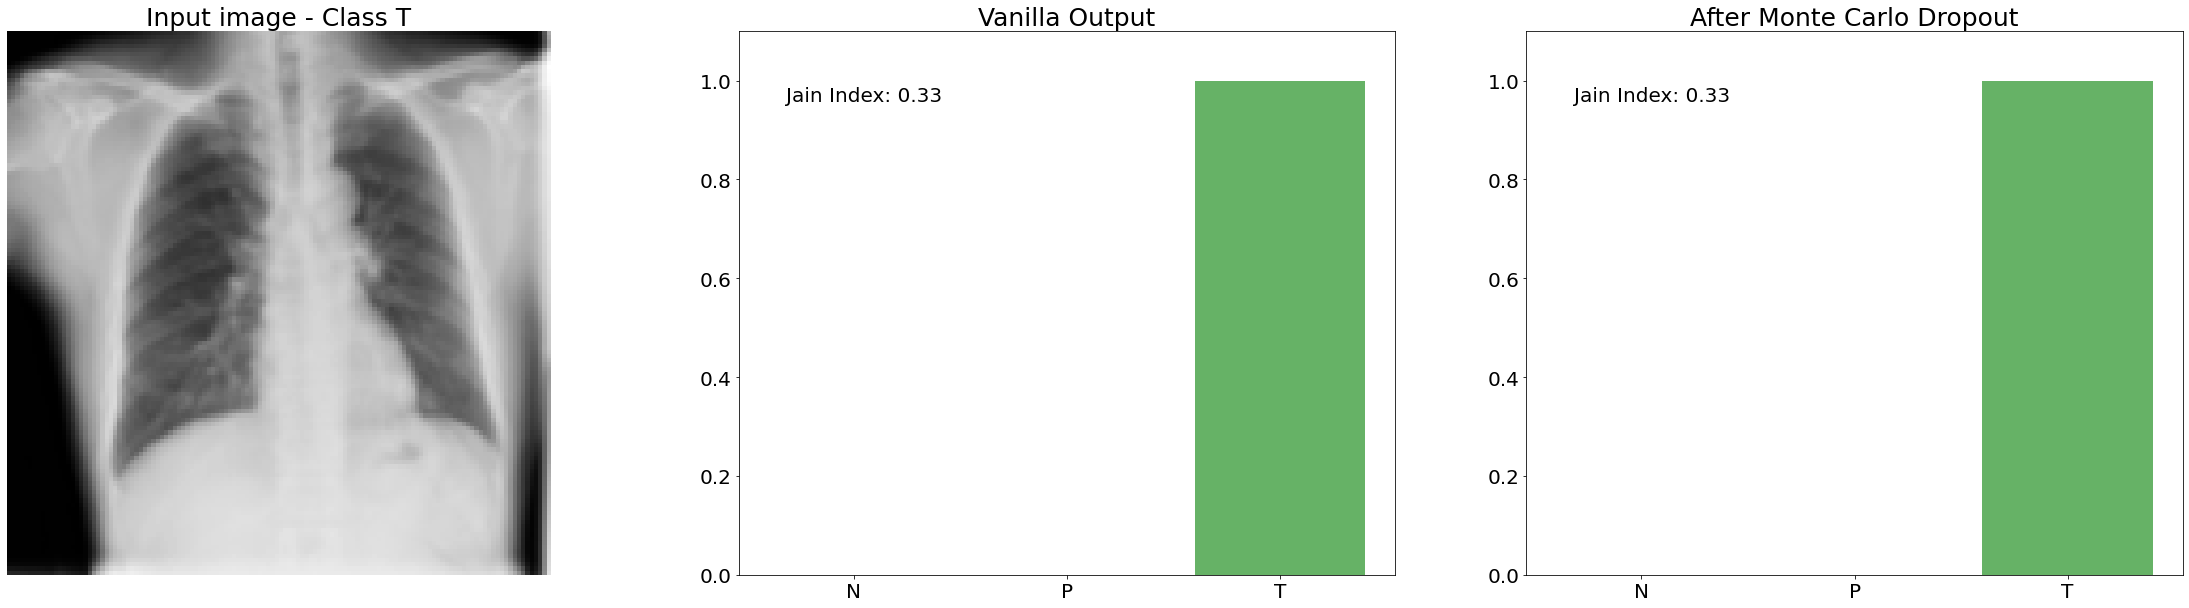

In [29]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(40,10))

ax1.imshow(well_predicted_image_fp,cmap='gray')
ax1.axis('off')
ax1.set_title('Input image - Class T',fontsize=25)

ax2.bar(range(3),classical_prediction_well,color= 'green',alpha=0.6,label='Vanilla {}'.format(i))
ax2.set_ylim([0, 1.1])
ax2.set_xticks(range(3))#)#,fontsize=20)
ax2.set_xticklabels(['N','P','T'],fontsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_title('Vanilla Output',fontsize=25)
ax2.text(0.05,0.95,'Jain Index: '+str(round(jain_fairness(classical_prediction_well),2)), ha='center', va='bottom',fontsize=20)


ax3.bar(range(3), mean_prediction_well, color = 'green',alpha=0.6,label='MonteCarloDropout {}'.format(i))
ax3.set_ylim([0, 1.1])
ax3.set_xticks(range(3))#,fontsize=20)
ax3.set_xticklabels(['N','P','T'],fontsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax3.set_title('After Monte Carlo Dropout',fontsize=25) 
ax3.text(0.05,0.95,'Jain Index: '+str(round(jain_fairness(mean_prediction_well),2)), ha='center', va='bottom',fontsize=20)

Text(1.95, 0.95, 'Jain Index: 0.52')

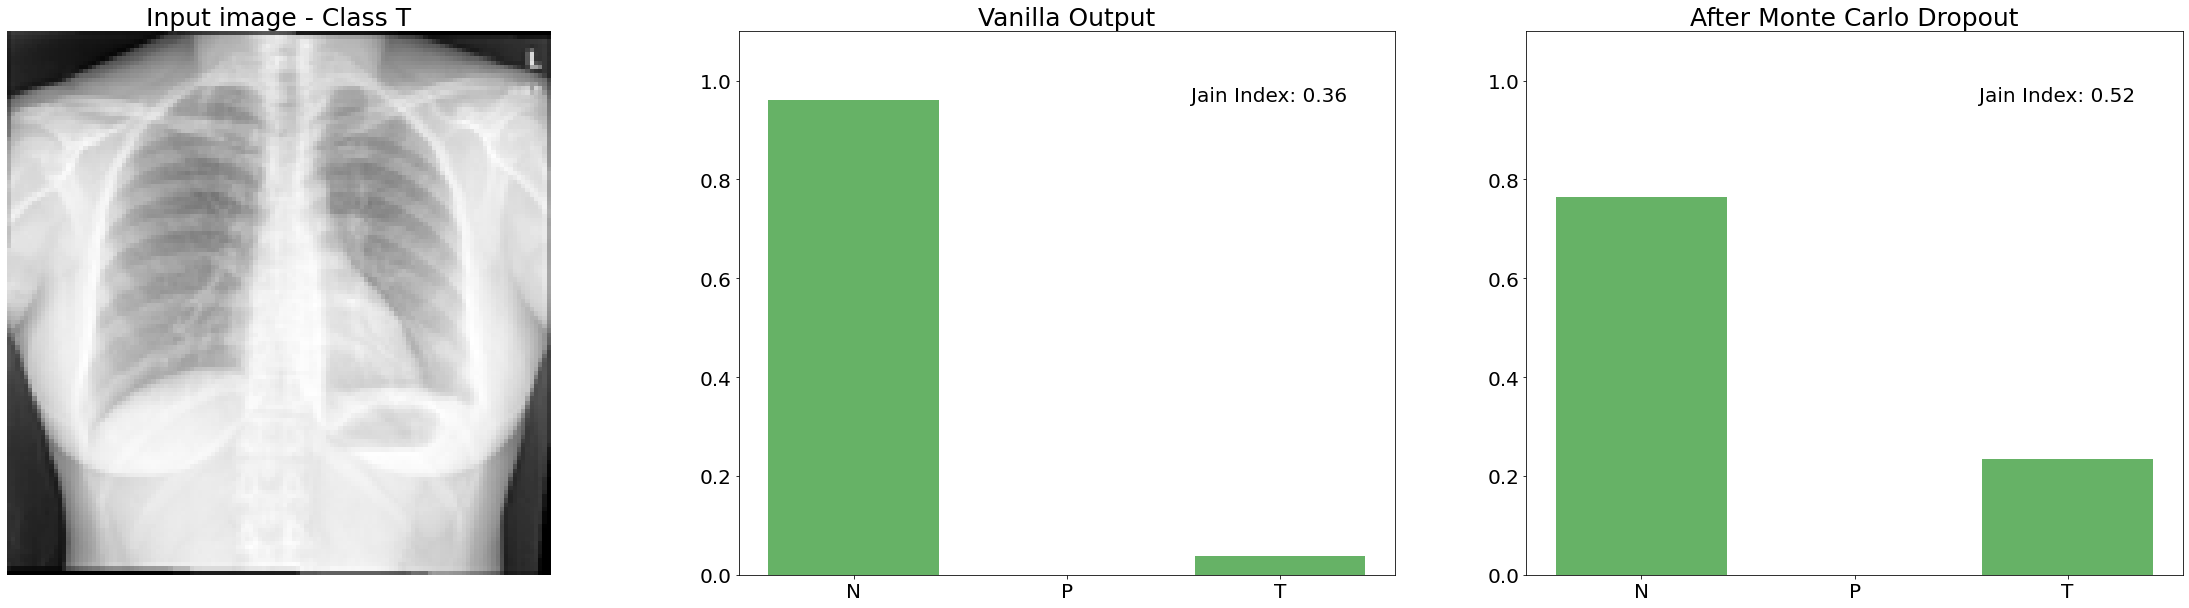

In [32]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(40,10))

ax1.imshow(wrong_predicted_image_fp,cmap='gray')
ax1.axis('off')
ax1.set_title('Input image - Class T',fontsize=25)

ax2.bar(range(3),classical_prediction_wrong,color= 'green',alpha=0.6,label='Vanilla {}'.format(i))
ax2.set_ylim([0, 1.1])
ax2.set_xticks(range(3))#,fontsize=20)
ax2.set_xticklabels(['N','P','T'],fontsize=20)
ax2.tick_params(axis='y', labelsize=20)
ax2.set_title('Vanilla Output',fontsize=25)
ax2.text(1.95,0.95,'Jain Index: '+str(round(jain_fairness(classical_prediction_wrong),2)), ha='center', va='bottom',fontsize=20)


ax3.bar(range(3), mean_prediction_wrong, color = 'green',alpha=0.6,label='MonteCarloDropout {}'.format(i))
ax3.set_ylim([0, 1.1])
ax3.set_xticks(range(3))#,fontsize=20)
ax3.set_xticklabels(['N','P','T'],fontsize=20)
ax3.tick_params(axis='y', labelsize=20)
ax3.set_title('After Monte Carlo Dropout',fontsize=25)
ax3.text(1.95,0.95,'Jain Index: '+str(round(jain_fairness(mean_prediction_wrong),2)), ha='center', va='bottom',fontsize=20)

##Plot of all visual XAI models together

In [ ]:
a=randint(0,len(lista_imagini))
# Open an image file
original_image = Image.open(os.path.join(T_target_path, lista_imagini[a])).resize((128,128))

exp_image= np.array(original_image)
exp_image = cv2.medianBlur(exp_image,5)
exp_image_1channel = np.expand_dims(exp_image,axis=-1)

exp_image=np.concatenate((exp_image_1channel,exp_image_1channel,exp_image_1channel),axis=-1)

image_to_be_explained_ = exp_image 
#####################GRAD-CAM
grad_cams,predictions,gradModel=GradCam(model,np.expand_dims(exp_image, axis=0),'block5_conv3',eps=10e-60,output_node=0)

img=np.array(original_image)
img = np.expand_dims(img,axis=-1)
img=np.concatenate((img,img,img),axis=-1)


prediction=np.argmax(predictions)
        
        #print(classes[i])
        
heatmap=grad_cams[prediction]
        
        #print(i,hmin,hmax,hmina,hmaxa)    

        # Rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

        # Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

        # Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

        # Create an image with RGB colorized heatmap
jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))

        #heatmap = sigmoid(heatmap, 50, thresh, 1)

jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

        # Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

###########LIME
explanation = explainer.explain_instance(exp_image.astype('double'), model.predict,  hide_color=0, num_samples=10000)
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
##########OCCLUSION

sense_map, inverted_sense_map = get_occlusion(image_to_be_explained_, 1, 15, 3)


fig, axes = plt.subplots(1, 5, figsize=(25,50))

axes[0].imshow(img,cmap='gray')
axes[0].set_title("Inuput image - "+labels[1])
axes[0].axis('off')

axes[1].imshow(superimposed_img)

axes[2].imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())

axes[3].imshow(image_to_be_explained_, cmap='gray')
im=axes[3].imshow(sense_map, cmap='YlGnBu', alpha=0.7)
axes[3].set_title("Traditional occlusion")
axes[3].axis('off')
cax = make_axes_locatable(axes[1]).append_axes("right", size="5%", pad=0.05) 
fig.colorbar(im, cax=cax)

axes[4].imshow(image_to_be_explained_, cmap='gray')
im=axes[4].imshow(inverted_sense_map, cmap='YlGnBu', alpha=0.5)
axes[4].set_title("Inverted occlusion")
axes[4].axis('off')
cax = make_axes_locatable(axes[2]).append_axes("right", size="5%", pad=0.05) 
fig.colorbar(im, cax=cax)